In [8]:
import wandb
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

In [9]:
# --- HELPER FUNCTION ---
def process_single_run(run):
    try:
        # Skip if not finished to save time
        if run.state != "finished":
            return None

        # 1. Extract Config
        try:
            opt_args = run.config.get("optimizer_params", {}).get("args", {})
            safety_factor = opt_args.get("polar_safety")
        except Exception:
            safety_factor = None

        # 2. Download History
        # scan_history handles pagination to prevent 500 Errors
        history_generator = run.scan_history()
        history_list = [row for row in history_generator]

        if not history_list:
            return None

        # 3. Build DataFrame
        df = pd.DataFrame(history_list)

        # 4. Add Metadata
        df["run_id"] = run.id
        df["run_name"] = run.name
        df["sweep_id"] = run.sweep.id if run.sweep else "no_sweep"
        df["safety_factor"] = safety_factor

        return df

    except Exception as e:
        return None

# --- 1. ROBUST LOADER ---
def load_data(filepath="./data/master_project_data.csv"):
    """
    Loads the CSV with low_memory=False to handle mixed types
    (fixing the DtypeWarning) and parses known numeric columns.
    """
    print(f"Loading {filepath}...")
    # low_memory=False forces pandas to read the whole file to determine dtypes
    # instead of guessing chunk-by-chunk.
    df = pd.read_csv(filepath, low_memory=False)
    print(f"Loaded {len(df)} rows. Columns found: {len(df.columns)}")
    return df

# --- 2. FAST PLOTTER ---
def plot_fast(df, x_col, y_col, hue_col=None, title=None, log_scale=False):
    """
    Wrapper for Seaborn lineplot.
    """
    plt.figure(figsize=(10, 6))

    sns.lineplot(
        data=df,
        x=x_col,
        y=y_col,
        hue=hue_col,
        errorbar="sd" # Shows Standard Deviation shadow
    )

    if log_scale:
        plt.yscale("log")

    if title:
        plt.title(title)
    else:
        plt.title(f"{y_col} vs {x_col}")

    plt.grid(True, alpha=0.3)
    plt.show()

# --- 3. THE DEBUGGER (Why your plot failed) ---
def find_col(df, keyword):
    """Prints all columns containing the keyword (e.g., 'loss')"""
    matches = [c for c in df.columns if keyword in str(c).lower()]
    print(f"Columns matching '{keyword}':")
    print(matches)

In [3]:
# --- CONFIGURATION ---
ENTITY = "justin_yang-university-of-california-berkeley"
PROJECT = "cs182-project-GPT-opt"
DATA_DIR = "./data"
OUTPUT_FILE = "master_project_data.csv"
MAX_WORKERS = 64  # Download 64 runs at once (Safe for W&B API limits)

# 1. Setup
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

api = wandb.Api(timeout=60)

print(f"Fetching run list from {ENTITY}/{PROJECT}...")

# 2. Get All Runs (This is fast, just a list of IDs)
# Note: We get runs directly from the Project object to cover ALL sweeps
runs = api.runs(f"{ENTITY}/{PROJECT}")

print(f"Found {len(runs)} total runs.")

Fetching run list from justin_yang-university-of-california-berkeley/cs182-project-GPT-opt...
Found 491 total runs.


In [4]:
# --- MAIN SCRIPT ---
print(f"Starting parallel download with {MAX_WORKERS} workers...")
all_dataframes = []

# 3. Parallel Execution
# ThreadPoolExecutor handles the concurrency

all_dataframes = []

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = {executor.submit(process_single_run, run): run for run in runs}

    for future in tqdm(as_completed(futures), total=len(runs), desc="Downloading"):
        result = future.result()
        if result is not None and not result.empty:
            all_dataframes.append(result)

if all_dataframes:
    print("Concatenating data...")
    # Sort=False suppresses the FutureWarning about column order
    master_df = pd.concat(all_dataframes, ignore_index=True, sort=False)

    save_path = os.path.join(DATA_DIR, OUTPUT_FILE)
    master_df.to_csv(save_path, index=False)
    print(f"DONE! Saved {len(master_df)} rows to {save_path}")
else:
    print("No valid data found.")

Starting parallel download with 64 workers...


Downloading: 100%|██████████| 491/491 [00:13<00:00, 37.38it/s]  


Concatenating data...


/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_72930/2122809291.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat(all_dataframes, ignore_index=True, sort=False)


DONE! Saved 79111 rows to ./data/master_project_data.csv


Loading ./data/master_project_data.csv...
Loaded 79111 rows. Columns found: 301
Columns matching 'loss':
['val/loss', 'train/loss']


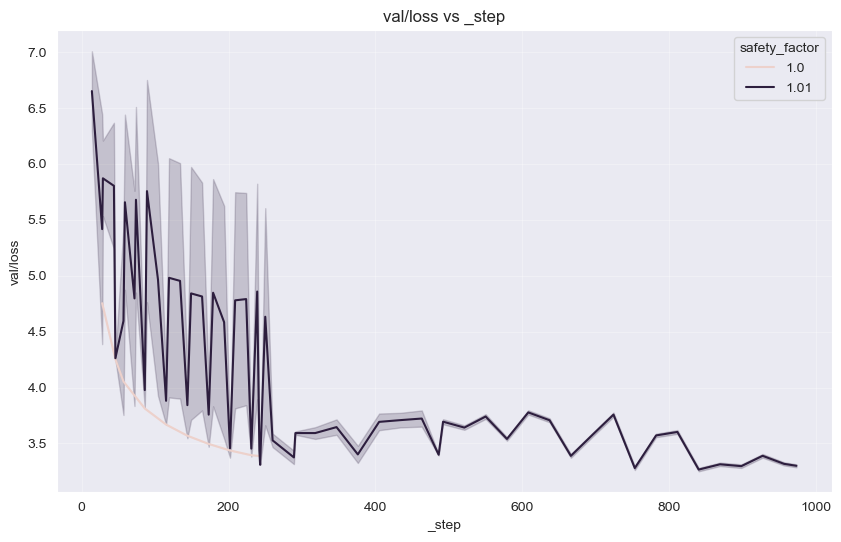

In [10]:
# 1. Load Data
df = load_data()

# 2. Find the REAL name for loss
find_col(df, "loss")

# 3. Plot using the CORRECT name found above
# Replace 'val/loss' with whatever the print statement above gave you
plot_fast(df, x_col="_step", y_col="val/loss", hue_col="safety_factor")

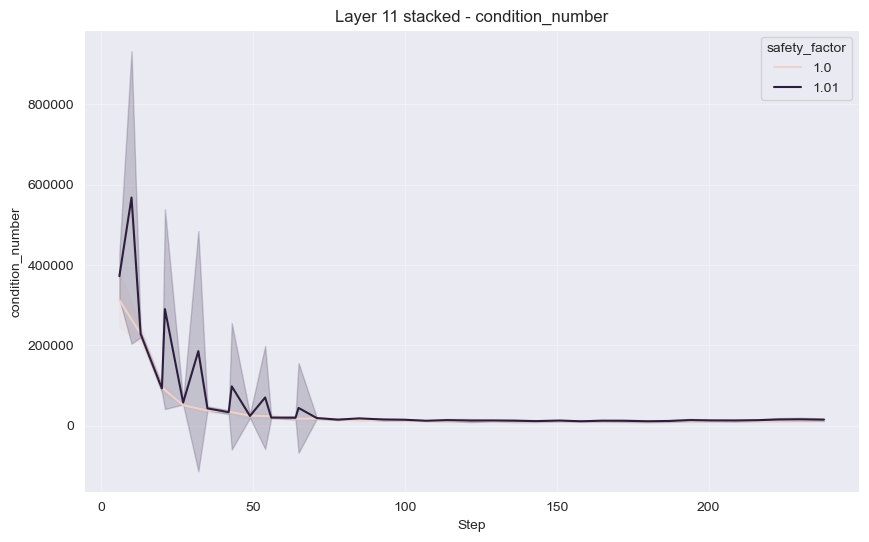

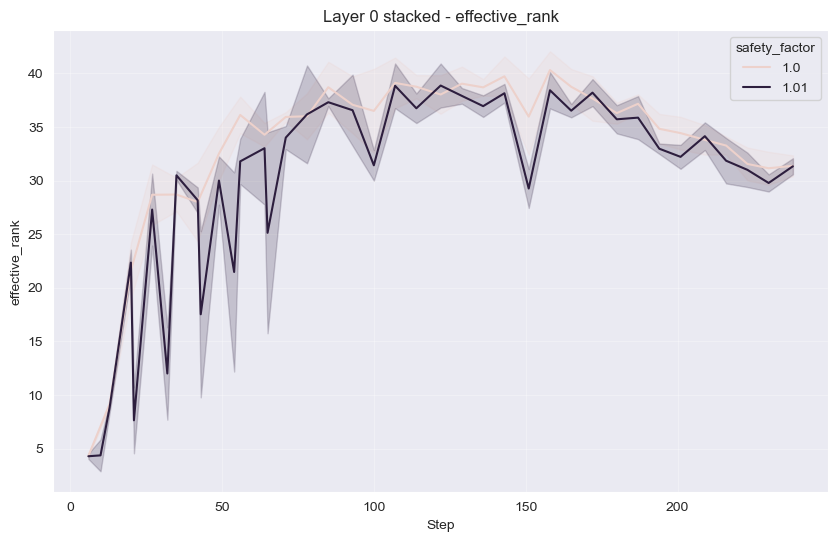

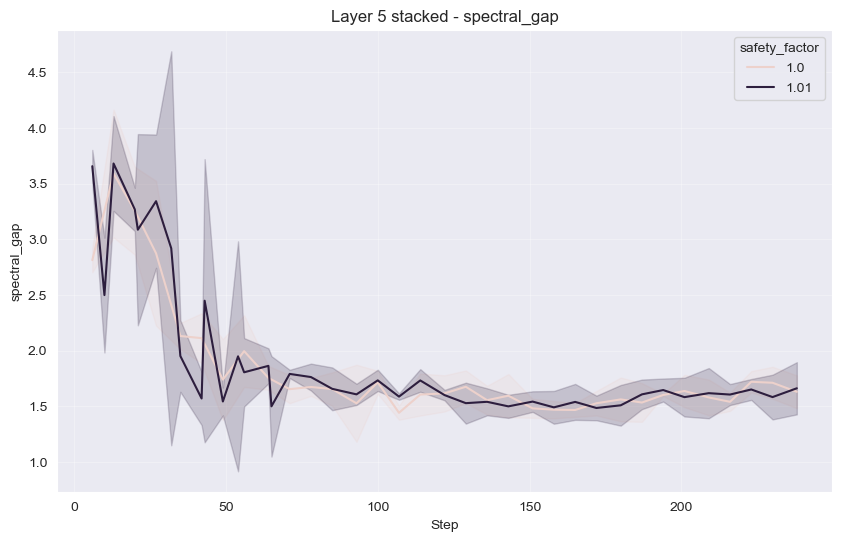

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load your downloaded data
# Ensure you ran the master_downloader.py script first!
df = pd.read_csv("./data/master_project_data.csv", low_memory=False)

# 2. Define the Universal Plotter
def plot_fast(df, layer, matrix, metric, param_name="safety_factor"):
    col_name = f"svd/update_layer{layer}_{matrix}/{metric}"

    plt.figure(figsize=(10, 6))

    # Seaborn does all the math (Mean, Std Dev, Confidence Interval) for you
    sns.lineplot(
        data=df,
        x="_step",
        y=col_name,
        hue=param_name,
        errorbar="sd"
    )

    plt.title(f"Layer {layer} {matrix} - {metric}")
    plt.ylabel(metric)
    plt.xlabel("Step")
    plt.grid(True, alpha=0.3)
    plt.show()

# 3. Generate your 3 plots instantly
plot_fast(df, layer=11, matrix="stacked", metric="condition_number")
plot_fast(df, layer=0,  matrix="stacked", metric="effective_rank")
plot_fast(df, layer=5,  matrix="stacked", metric="spectral_gap")